# Binary Classification

Are houses in California in a neighborhood above a certain price?
* Interprete a problem as a classification question.
* Determine how modifying the classification threshold influences the model.





In [ ]:
import numpy as np

import pandas as pd
# adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

%tensorflow_version 2.x
import tensorflow as tf
tf.keras.backend.set_floatx('float32')

from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt

print("Required Modules imported.")

Required Modules imported.


## Get Data

[California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

* `train_df`, which contains the training set
* `test_df`, which contains the test set

In [ ]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
print('Training data fetched: ', train_df.shape)

test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
print('Test data fetched: ', test_df.shape)

Training data fetched:  (17000, 9)
Test data fetched:  (3000, 9)


In [ ]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


## Preprocess the data

* **Shuffle** the training data
* **Normalize** the training and test data
  * Convert each raw value (including the label) to its **Z-score**.
    * A **Z-score** is the **number of standard deviations from the mean for a particular raw value**.
    * `Z-score = (value - mean) / std.dev`
* **Create binary labels**
  * Set *threshold*
  * If label > threshold => label = 1
  * If label < threshold => label = 0

In [ ]:
## shuffle training data
train_df = train_df.reindex(np.random.permutation(train_df.index))

In [ ]:
## normalize the training and testing set using z-value
train_df_norm = (train_df - train_df.mean())/train_df.std()
test_df_norm = (test_df - test_df.mean())/test_df.std()

In [ ]:
## create binary labels for training set
threshold_train = train_df_norm.median_house_value.quantile(.75) # 75 percentile
train_df_norm["median_house_value_is_high"] = train_df_norm["median_house_value"] > threshold_train # binary label based on threshold
train_df_norm["median_house_value_is_high"] = train_df_norm["median_house_value_is_high"].astype(float) # bool to float

## create binary labels for test set
threshold_test = test_df_norm.median_house_value.quantile(.75) # 75 percentile
test_df_norm["median_house_value_is_high"] = test_df_norm["median_house_value"] > threshold_test # binary label based on threshold
test_df_norm["median_house_value_is_high"] = test_df_norm["median_house_value_is_high"].astype(float) # bool to float

## Explore the training data
* Check the features
* Find the correlation features with label

In [ ]:
train_df_norm.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_is_high
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.2
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4
min,-2.4,-1.4,-2.2,-1.2,-1.3,-1.2,-1.3,-1.8,-1.7,0.0
25%,-1.1,-0.8,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.8,0.0
50%,0.5,-0.6,0.0,-0.2,-0.3,-0.2,-0.2,-0.2,-0.2,0.0
75%,0.8,1.0,0.7,0.2,0.3,0.3,0.3,0.5,0.5,0.0
max,2.6,3.0,1.9,16.2,14.0,29.8,14.5,5.8,2.5,1.0


In [ ]:
train_df_norm.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_is_high
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.1
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1,0.0
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7,0.6
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0,0.8
median_house_value_is_high,-0.1,-0.1,0.1,0.1,0.0,-0.0,0.0,0.6,0.8,1.0


## Feature Representation

* Pick the features with significant correlation with the label
* Represent the selected features in the required form
* Create a feature layer to be fed to the model

In [ ]:
# Feature representation 

# Create location = cross of latitute and longitude 
# To Floating-point
latitude_numeric = tf.feature_column.numeric_column("latitude")
longitude_numeric = tf.feature_column.numeric_column("longitude")
# To Buckets
resolution_in_degrees = 1.0
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_numeric, latitude_boundaries)
longitude = tf.feature_column.bucketized_column(longitude_numeric, longitude_boundaries)
# Feature Cross
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
location = tf.feature_column.indicator_column(latitude_x_longitude)

# Create feature layer to be fed into the model. 
feature_columns = []
feature_columns.append(location)
feature_columns.append(tf.feature_column.numeric_column("housing_median_age"))
feature_columns.append(tf.feature_column.numeric_column("total_rooms"))
feature_columns.append(tf.feature_column.numeric_column("median_income"))
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 103), dtype=float32, numpy=
array([[-0.12627003,  0.        ,  0.        , ...,  0.        ,
        -0.25342685, -0.58609885],
       [ 0.9859942 ,  0.        ,  0.        , ...,  0.        ,
        -0.9911546 , -0.6365588 ],
       [ 0.19151975,  0.        ,  0.        , ...,  0.        ,
        -0.20416464, -0.13517044],
       ...,
       [-1.8741138 ,  0.        ,  0.        , ...,  0.        ,
         0.68978715,  1.4800063 ],
       [-0.6029547 ,  0.        ,  0.        , ...,  0.        ,
         0.5926778 ,  3.2860136 ],
       [-0.52350724,  0.        ,  0.        , ...,  0.        ,
        -0.97663796, -0.72738665]], dtype=float32)>

## Define functions for build and train a model, and plotting

* `create_model(my_learning_rate, feature_layer, my_metrics)`, which defines the model's topography.
* `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.
  * For classification, we use [sigmoid](https://developers.google.com/machine-learning/glossary#sigmoid_function) as the activation function. 
* `plot_curve`

In [ ]:
def create_model(lr, feature_layer, my_metrics):
  model = tf.keras.models.Sequential()
  model.add(feature_layer)
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation=tf.sigmoid),)
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=my_metrics,
      optimizer=tf.keras.optimizers.RMSprop(lr=lr),
  )
  return model        

def train_model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=shuffle)
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  return epochs, hist
  
def plot_curve(epochs, hist, list_of_metrics):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")
  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)
  plt.legend()

## Task 1: Create and Train Model with **Accuracy** metric

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 2s 2ms/step - loss: 0.7255 - accuracy: 0.2367
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6126 - accuracy: 0.3438
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5389 - accuracy: 0.6856
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4870 - accuracy: 0.8223
Epoch 5/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4565 - accuracy: 0.8357
Epoch 6/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4358 - accuracy: 0.8433
Epoch 7/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4149 - accuracy: 0.8449
Epoch 8/20
170/170 [==============================] - 0s 3ms/step - loss: 0.3999 - accuracy: 0.8437
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3905 - accurac

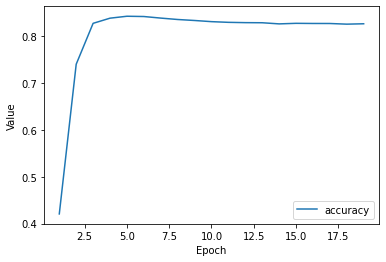

In [ ]:
# Set hyperparameters.
lr = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [tf.keras.metrics.BinaryAccuracy(
    name='accuracy', threshold=classification_threshold),
]

# Establish the model's topography.
my_model = create_model(lr, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

**Observation**: Accuracy gradually improves during training (until it can improve no more).

## Evaluate the Model

In [ ]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 3ms/step - loss: 0.3818 - accuracy: 0.8250


[0.3818299174308777, 0.824999988079071]

A perfect model would make 100% accurate predictions.
Our model makes 82% accurate predictions. 

**Note**: A model that always guesses *median_house_value_is_high* as False would be 75% accurate.

## Task 2: Create and Train model with **Accuracy, Precision, and Recall** metrics



Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 3ms/step - loss: 0.5931 - accuracy: 0.2968 - precision: 0.2597 - recall: 0.9893
Epoch 2/20
170/170 [==============================] - 1s 3ms/step - loss: 0.5084 - accuracy: 0.6354 - precision: 0.3966 - recall: 0.8992
Epoch 3/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4559 - accuracy: 0.7923 - precision: 0.5637 - recall: 0.7502
Epoch 4/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4223 - accuracy: 0.8366 - precision: 0.6750 - recall: 0.6395
Epoch 5/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4058 - accuracy: 0.8431 - precision: 0.7073 - recall: 0.6269
Epoch 6/20
170/170 [==============================] - 1s 3ms/step - loss: 0.3999 - accuracy: 0.8349 - precision: 0.6907 - recall: 0.6313
Epoch 7/20
170/170 [==============================] - 1s 4ms/step - 

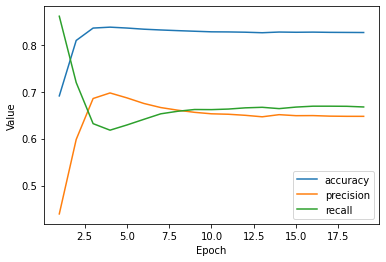

In [ ]:
# Set the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(name='precision', thresholds=classification_threshold),
      tf.keras.metrics.Recall(name='recall', thresholds=classification_threshold)
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

**Observation**: The precision and recall are somewhat in conflict. That is, improvements to one of those metrics may hurt the other metric.

## Task 3: Experiment with the classification threshold

What value of `classification_threshold` produces the highest accuracy?

classification threshold:  0.52
Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 4ms/step - loss: 0.6579 - accuracy: 0.2510 - precision: 0.2510 - recall: 1.0000
Epoch 2/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5533 - accuracy: 0.2859 - precision: 0.2584 - recall: 0.9928
Epoch 3/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4838 - accuracy: 0.6295 - precision: 0.3952 - recall: 0.9059
Epoch 4/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4408 - accuracy: 0.7801 - precision: 0.5314 - recall: 0.7783
Epoch 5/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4231 - accuracy: 0.8125 - precision: 0.6069 - recall: 0.7166
Epoch 6/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4033 - accuracy: 0.8198 - precision: 0.6149 - recall: 0.7245
Epoch 7/20
170/170 [================

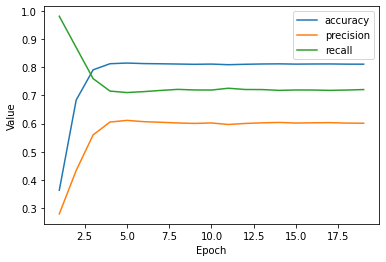

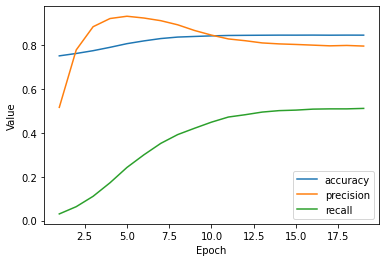

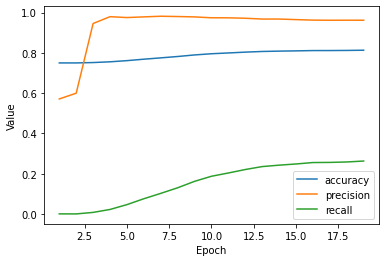

In [ ]:
classification_thresholds = [0.3, 0.52, 0.8]

for classification_threshold in classification_thresholds:

  # Set the hyperparameters.
  learning_rate = 0.001
  epochs = 20
  batch_size = 100

  label_name = "median_house_value_is_high"

  METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
        tf.keras.metrics.Precision(name='precision', thresholds=classification_threshold),
        tf.keras.metrics.Recall(name="recall", thresholds=classification_threshold)
  ]
  print('classification threshold: ', ct)

  my_model = create_model(learning_rate, feature_layer, METRICS)

  epochs, hist = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

  list_of_metrics_to_plot = ['accuracy', "precision", "recall"]
  plot_curve(epochs, hist, list_of_metrics_to_plot)

**Observation**: 
* A `classification_threshold` of slightly over 0.5 appears to produce the highest accuracy (about 84%).
* Raising the `classification_threshold` to 0.9 drops accuracy by about 4%. 
* Lowering `classification_threshold` to 0.3 drops accuracy by  about 4%. 

## Task 4: Summarize the model performance using **AUC**

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 3ms/step - loss: 0.6874 - auc: 0.5855
Epoch 2/20
170/170 [==============================] - 1s 3ms/step - loss: 0.5793 - auc: 0.7872
Epoch 3/20
170/170 [==============================] - 1s 3ms/step - loss: 0.5064 - auc: 0.8365
Epoch 4/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4622 - auc: 0.8523
Epoch 5/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4392 - auc: 0.8597
Epoch 6/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4143 - auc: 0.8607
Epoch 7/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4064 - auc: 0.8615
Epoch 8/20
170/170 [==============================] - 1s 3ms/step - loss: 0.3974 - auc: 0.8541
Epoch 9/20
170/170 [==============================] - 1s 4ms/step - loss: 0.3880 - auc: 0.8607
Epoch 10/20
170/170 [==============

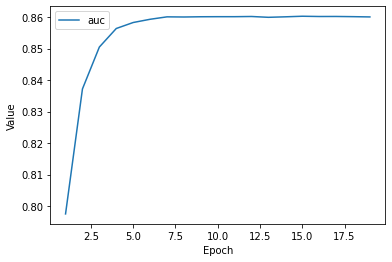

In [ ]:
# Set the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for classification models.
METRICS = [tf.keras.metrics.AUC(name='auc', num_thresholds=100)]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metric vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)